## Compare results from TSS to RNA-seq results

In [2]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']


tss_annotation = doc['tss_annotation']


import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 13)


## Load 
### 1. CHO rna matrix
### 2. TSS DataFrame
### 3. CHO filtered peak file

### 1.

In [2]:
cho_rna_file = doc["cho_rna_file"]
cho_rna = pd.read_csv(cho_rna_file,sep="\t",index_col=0)
cho_rna = cho_rna.iloc[:,1:]
cho_rna = np.log10(cho_rna+1)
cho_rna

,1,2,3,4,5,6,7,8,9,10,...,SRR2922605,SRR2922606,SRR3401745,SRR3401746,SRR3401747,SRR3401748,SRR3401749,SRR3401750,SRR3401751,SRR3401752
gid,,,,,,,,,,,,,,,,,,,,,
gene_10,1.206581,1.190397,1.266534,1.299687,1.250293,1.241380,1.216064,1.228527,1.158073,1.248399,...,0.581864,0.166502,1.008010,1.081447,1.030411,1.005240,0.917667,0.994322,1.047777,1.019441
gene_100,0.095228,0.109453,0.048500,0.111266,0.114090,0.070754,0.164908,0.189990,0.164238,0.199324,...,0.252942,0.034374,0.180736,0.234086,0.797508,1.154288,1.167227,1.346290,0.815261,1.262120
gene_10000_1,0.428575,0.401795,0.524840,0.444983,0.526040,0.476838,0.334874,0.137845,0.206931,0.208200,...,0.364137,0.067344,0.158058,0.051757,0.572867,0.446828,0.444490,0.314167,0.611009,0.438655
gene_10000_10,0.000000,0.000000,0.208872,0.250192,0.079810,0.000000,0.583274,0.000000,0.807168,0.525297,...,0.000000,0.000000,0.263660,0.543877,1.173298,0.769846,1.102431,0.989120,1.245640,1.187744
gene_10000_11,0.540125,0.554644,0.441339,0.523375,0.592315,0.641386,0.711139,0.619822,0.713691,0.878432,...,0.138565,0.002109,0.747154,0.509267,0.844030,0.569484,0.634222,0.661452,0.848332,0.848909
gene_10000_12,1.677752,1.671340,1.714967,1.775541,1.746701,1.733816,1.447307,1.477983,1.496814,1.513296,...,1.126781,0.368401,1.556099,1.481034,1.341566,1.205615,1.503668,1.487355,1.433426,1.199199
gene_10000_2,0.200030,0.181347,0.215802,0.243011,0.269654,0.268938,0.253915,0.364867,0.371840,0.364880,...,0.137446,0.024128,0.286587,0.194207,0.403559,0.229081,0.295641,0.313792,0.395364,0.365530
gene_10000_3,0.071477,0.029705,0.082297,0.068219,0.202137,0.074280,0.099487,0.066516,0.079761,0.075437,...,0.099156,0.027899,0.000000,0.074793,0.138662,0.114292,0.081876,0.000000,0.075998,0.044111
gene_10000_4,0.040378,0.055501,0.046175,0.028485,0.065582,0.016580,0.043009,0.114510,0.099225,0.000000,...,0.049390,0.002582,0.020196,0.062010,0.024553,0.061873,0.106745,0.064303,0.040425,0.048334


In [17]:
for i in cho_rna.index:
    c = i.split("_")
    if len(c) == 3 and (c[1].isdigit() and c[2].isdigit())
cho_rna.index.str.split("_")

Index([             [u'gene', u'10'],             [u'gene', u'100'],
           [u'gene', u'10000', u'1'],    [u'gene', u'10000', u'10'],
          [u'gene', u'10000', u'11'],    [u'gene', u'10000', u'12'],
           [u'gene', u'10000', u'2'],     [u'gene', u'10000', u'3'],
           [u'gene', u'10000', u'4'],     [u'gene', u'10000', u'5'],
       ...
       [u'gene', u'asmbl', u'65847'], [u'gene', u'asmbl', u'65848'],
       [u'gene', u'asmbl', u'65850'], [u'gene', u'asmbl', u'65854'],
       [u'gene', u'asmbl', u'68438'], [u'gene', u'asmbl', u'81468'],
       [u'gene', u'asmbl', u'81469'], [u'gene', u'asmbl', u'83539'],
       [u'gene', u'asmbl', u'83541'], [u'gene', u'asmbl', u'84694']],
      dtype='object', name=u'gid', length=38554)

### Load picr_final start site file, since the RNA-seq was mapped to that genome

In [3]:
old_mrna = pd.read_csv("/data/isshamie/genome/picr_final/mRNA_final.peak",sep="\t")
old_mrna

,transcript_id,Chr,Start,End,Strand,actual_start,ID.1,Parent,gene_id,gene,transcript_id.1,cs,ID.1.1,ID
0,asmbl_1,picr_0,9,11,+,10,asmbl_1,gene_1_1,gene_1_1,gene_1,asmbl_1,5,asmbl_1,asmbl_1
1,asmbl_2,picr_0,175,177,+,176,asmbl_2,gene_1_2,gene_1_2,SERHL,asmbl_2,2,asmbl_2,asmbl_2
2,asmbl_3,picr_0,3879,3881,+,3880,asmbl_3,gene_1_3,gene_1_3,gene_1,asmbl_3,5,asmbl_3,asmbl_3
3,asmbl_5,picr_0,44541,44543,-,44542,asmbl_5,gene_2,gene_2,RRP7A,asmbl_5,2,asmbl_5,asmbl_5
4,asmbl_6,picr_0,45911,45913,-,45912,asmbl_6,gene_2,gene_2,RRP7A,asmbl_6,1,asmbl_6,asmbl_6
5,asmbl_4,picr_0,46629,46631,-,46630,asmbl_4,gene_2,gene_2,RRP7A,asmbl_4,1,asmbl_4,asmbl_4
6,asmbl_7,picr_0,44596,44598,-,44597,asmbl_7,gene_2,gene_2,RRP7A,asmbl_7,1,asmbl_7,asmbl_7
7,asmbl_8,picr_0,44596,44598,-,44597,asmbl_8,gene_2,gene_2,RRP7A,asmbl_8,1,asmbl_8,asmbl_8
8,asmbl_9,picr_0,44567,44569,-,44568,asmbl_9,gene_2,gene_2,RRP7A,asmbl_9,1,asmbl_9,asmbl_9
9,asmbl_10,picr_0,44512,44514,-,44513,asmbl_10,gene_2,gene_2,RRP7A,asmbl_10,1,asmbl_10,asmbl_10


In [ ]:
## Create map from gene_id to gene
gene_id = cho_rna.index.values
gene_id_dict = dict()
for i in tqdm.tqdm(gene_id):
    vals = old_mrna.loc[old_mrna["gene_id"] == i,"gene"].values
    if len(vals) > 0:
        gene_id_dict[i] = vals[0]


  9%|▉         | 3423/38554 [00:23<04:05, 142.91it/s]

In [90]:
from collections import defaultdict

inv_gene_id_dict = defaultdict(list)
for i in gene_id_dict:
    inv_gene_id_dict[gene_id_dict[i]].append(i)

### Combine gene_ids with similar genes by taking the median expression

In [4]:
cho_rna_gnames = cho_rna.groupby(old_mrna.set_index(["gene_id"],)["gene"].to_dict()).median()

### 2. 

In [5]:
gene_df = pickle.load(open("Results/tss_annotation/gene_df_02.p","rb"))
gene_df

,peaks,closest_to_X_numberOfPeaks,bin_-1000_1000,sameStrand_bin_-1000_1000,samples,minDistance,minDistancePeak,maxValue,maxPeakId,maxSample,Chr,Start,End,Strand,gene,transcript,maxSamples,hasGene,Number of SS
Bmp4,"[1394, 3038, 17698, 17726, 21888, 24414, 35067...",129,"[90264, 97971, 124234, 163408, 181215, 308710,...","[90264, 181215, 308710, 348823]","[MiscOrgans_START1_and_MiscOrgans_startinput1,...",27.000000,308710,11864.6,308710,NaN,NW_020822366.1,724583,724584,-,Bmp4,XM_027386528.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,4
Cdkn3,"[17679, 17707, 68904, 83014, 89129, 99005, 108...",36,"[138244, 237253]",[237253],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",74.000000,237253,15.3,237253,NaN,NW_020822366.1,1085509,1085510,+,Cdkn3,XM_027386531.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1
Cnih1,"[14157, 68988, 69200, 116089, 132667, 167473, ...",17,"[132667, 298307, 350581, 353645]",[298307],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",88.000000,298307,57.2,298307,NaN,NW_020822366.1,1114325,1114326,-,Cnih1,XM_027386534.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1
Gmfb,"[34817, 35013, 35070, 86845, 97343, 120275, 12...",16,"[35013, 97343, 120275, 122677, 161643, 268973,...",[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0
Cgrrf1,"[5407, 35121, 224603, 293332, 306506, 338794, ...",10,"[5407, 293332, 306506, 348288, 414132]",[348288],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",68.000000,348288,144.9,348288,NaN,NW_020822366.1,1159951,1159952,+,Cgrrf1,XM_027386536.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1
Samd4a,"[7315, 12014, 14154, 35119, 68906, 69060, 6909...",115,"[165659, 226267, 309749, 310411, 334958, 34259...","[334958, 342596, 509869]","[MiscOrgans_START1_and_MiscOrgans_startinput1,...",-18.000000,342596,21.2,342596,NaN,NW_020822366.1,1214823,1214824,+,Samd4a,XM_027386537.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,3
Gch1,"[10177, 10874, 17708, 69091, 71579, 99009, 108...",33,"[154630, 238436, 243948]",[243948],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",9.000000,243948,51.1,243948,NaN,NW_020822366.1,1513786,1513787,-,Gch1,XM_027386540.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1
Wdhd1,"[71488, 71580, 71609, 224664, 276542, 398192, ...",12,[508092],[508092],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",-12.000000,508092,45.3,508092,NaN,NW_020822366.1,1605115,1605116,-,Wdhd1,XM_027386542.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1
Socs4,"[160861, 469408]",2,[160861],[160861],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",26.000000,160861,41,160861,NaN,NW_020822366.1,1605318,1605319,+,Socs4,XM_027386543.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1
Mapk1ip1l,"[5646, 35115, 68908, 68990, 69092, 71581, 1373...",23,"[5646, 226067, 293802, 414114, 475107]",[475107],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",33.000000,475107,52,475107,NaN,NW_020822366.1,1634603,1634604,+,Mapk1ip1l,XM_027386545.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1


### 3.

In [6]:
peaks_folder = "Results/tss_annotation_peaks/"
all_peaks_file = "Results/merged/samples.merge"

In [7]:
tissue="CHO"
curr_inds = set()
for i in glob.glob(os.path.join(peaks_folder,"merged*"+tissue+"*")):
    curr_inds = curr_inds | (set(pd.read_csv(i,sep='\t',index_col=0).index))

tissue_peaks = pd.read_csv(all_peaks_file,index_col=0,sep="\t")
tissue_peaks = tissue_peaks.loc[curr_inds]
tissue_peaks

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Chr,Start,End,Strand,Stat,Parent files,Total subpeaks,f04_peaks/MiscOrgans_START1_and_MiscOrgans_startinput1,f04_peaks/Liver_START2_and_Liver_startinput1,f04_peaks/Brain_GROCap1_and_Brain_GRO1,...,f04_peaks/MiscOrgans_START2_and_MiscOrgans_startinput1,f04_peaks/Spleen_START1_and_Spleen_startinput1,f04_peaks/Lung_START2_and_Lung_startinput1,f04_peaks/CHO_START1_and_CHO_startinput1,f04_peaks/FemaleReproductive_START1_and_FemaleReproductive_startinput1,f04_peaks/Kidney_START2_and_Kidney_startinput1,f04_peaks/Kidney_GROCap1_and_Kidney_GRO1,f04_peaks/CHO_GROCap1_and_CHO_GRO1,f04_peaks/BMDMwt_GROCap1_and_BMDMwt_GRO1,f04_peaks/Spleen_START2_and_Spleen_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
4,NW_020822601.1,37427816,37427999,+,129.031738,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,23,NW_020822601.1-18,NaN,NW_020822601.1-1445,...,NW_020822601.1-52,NW_020822601.1-123,NaN,NW_020822601.1-41,NaN,NaN,NW_020822601.1-1949,NW_020822601.1-992,NW_020822601.1-2287,NW_020822601.1-12
234838,NW_020822657.1,14724108,14724304,+,14.681000,f04_peaks/Brain_GROCap1_and_Brain_GRO1|f04_pea...,10,NaN,NaN,NW_020822657.1-48,...,NaN,NaN,NaN,NaN,NaN,NaN,NW_020822657.1-38,NW_020822657.1-23,NW_020822657.1-91,NW_020822657.1-28
6,NW_020822577.1,6314085,6314339,+,11.444000,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,25,NW_020822577.1-68,NW_020822577.1-6,NaN,...,NW_020822577.1-46,NW_020822577.1-183,NaN,NW_020822577.1-193,NaN,NW_020822577.1-32,NaN,NW_020822577.1-344,NW_020822577.1-859,NW_020822577.1-411
8,NW_020822435.1,461540,462075,-,6.744815,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,27,NW_020822435.1-25,NaN,NW_020822435.1-42,...,NW_020822435.1-30,NW_020822435.1-30,NW_020822435.1-57,NW_020822435.1-23,NaN,NaN,NW_020822435.1-73,NaN,NW_020822435.1-17,NW_020822435.1-30
152919,NW_020822468.1,1235648,1236320,+,3.138035,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,29,"NW_020822468.1-375,NW_020822468.1-582",NaN,NW_020822468.1-802,...,NW_020822468.1-485,NW_020822468.1-480,NW_020822468.1-220,NW_020822468.1-292,NW_020822468.1-535,NW_020822468.1-226,NaN,"NW_020822468.1-469,NW_020822468.1-526",NW_020822468.1-1218,NaN
131086,NW_020822636.1,2649666,2649894,+,4.872727,f04_peaks/Brain_GROCap1_and_Brain_GRO1|f04_pea...,11,NaN,NaN,NW_020822636.1-43,...,NaN,NaN,NaN,NaN,NaN,NaN,NW_020822636.1-113,NW_020822636.1-133,NaN,NaN
16,NW_020822606.1,271041,271338,-,3.848000,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,15,NW_020822606.1-229,NaN,NaN,...,NW_020822606.1-272,NW_020822606.1-104,NaN,NW_020822606.1-213,NaN,NW_020822606.1-84,NaN,NW_020822606.1-330,NaN,NW_020822606.1-150
21,NW_020822610.1,1876044,1876253,-,20.085806,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,31,NW_020822610.1-82,NW_020822610.1-114,NW_020822610.1-281,...,NW_020822610.1-66,NW_020822610.1-27,NW_020822610.1-21,NW_020822610.1-9,NW_020822610.1-43,NW_020822610.1-45,NaN,NW_020822610.1-70,NW_020822610.1-131,NW_020822610.1-222
131094,NW_020822601.1,55947993,55948205,-,30.001291,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,31,NW_020822601.1-172,NaN,NW_020822601.1-157,...,NW_020822601.1-232,NW_020822601.1-373,NW_020822601.1-174,NW_020822601.1-271,NW_020822601.1-242,NaN,NW_020822601.1-227,NW_020822601.1-46,NW_020822601.1-130,NW_020822601.1-359


In [8]:
gene_df.index = gene_df.index.str.upper()
has_peak = cho_rna_gnames.index.isin(gene_df.index)

In [9]:
has_peak.sum()

14041

# Analysis

## Chart comparing RNA-seq in genes that have TSS and those that dont

In [10]:
in_cho = gene_df[gene_df['samples'].apply(lambda x: tissue in ' '.join(x))].index
not_in_cho = gene_df[gene_df['samples'].apply(lambda x: tissue not in ' '.join(x))].index
in_any_sample_but_cho = gene_df[gene_df['hasGene']].index.difference(in_cho)
in_no_sample = gene_df[~gene_df['hasGene']].index

In [11]:
len(in_any_sample_but_cho)+len(in_no_sample)

11534

In [12]:
gene_stats = cho_rna_gnames.transpose().describe()

In [13]:
gene_stats

,110KD_PLAKN,1A01_PONPY,1OKO_GORGO,A1AT_MESAU,A1BG,A1CF,A1I3,A1M,A2M,A2ML1,...,gene_asmbl_65847,gene_asmbl_65848,gene_asmbl_65850,gene_asmbl_65854,gene_asmbl_68438,gene_asmbl_81468,gene_asmbl_81469,gene_asmbl_83539,gene_asmbl_83541,gene_asmbl_84694
count,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,...,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000
mean,0.028342,0.028662,0.265856,0.007705,0.007287,0.008531,0.000041,0.053976,0.230791,0.002389,...,0.702685,0.702687,0.060877,0.702699,2.033030,1.499263,2.411560,1.642705,0.211456,1.024676
std,0.051479,0.052680,0.203282,0.111343,0.106837,0.051464,0.001371,0.113637,0.237083,0.019681,...,0.234009,0.234009,0.186246,0.234009,0.375051,0.541849,0.427414,0.442996,0.419287,0.496885
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.008305,0.000000,0.108446,0.000000,0.000000,0.000000,0.000000,0.006068,0.027857,0.000000,...,0.520266,0.520266,0.000000,0.520266,1.940802,1.377626,2.348494,1.438964,0.000000,0.742653
50%,0.019962,0.000000,0.254236,0.000000,0.000000,0.000000,0.000000,0.035331,0.164891,0.000000,...,0.748332,0.748476,0.000000,0.748398,2.093146,1.625005,2.489229,1.794916,0.000000,1.193776
75%,0.035376,0.044386,0.400485,0.000000,0.000000,0.000000,0.000000,0.069142,0.368028,0.000000,...,0.891290,0.891273,0.000000,0.891184,2.220840,1.825187,2.607043,1.942226,0.000000,1.394019
max,0.897628,0.497202,1.116569,2.921680,2.845626,1.296480,0.052879,2.300752,1.571206,0.345327,...,1.131536,1.131536,1.791509,1.131536,2.719708,2.599238,3.420501,2.439222,3.088941,1.861233


In [14]:
import pylab

In [15]:
def suplabel(axis,label,label_prop=None,
             labelpad=5,
             ha='center',va='center'):
    ''' Add super ylabel or xlabel to the figure
    Similar to matplotlib.suptitle
    axis       - string: "x" or "y"
    label      - string
    label_prop - keyword dictionary for Text
    labelpad   - padding from the axis (default: 5)
    ha         - horizontal alignment (default: "center")
    va         - vertical alignment (default: "center")
    '''
    fig = pylab.gcf()
    xmin = []
    ymin = []
    for ax in fig.axes:
        xmin.append(ax.get_position().xmin)
        ymin.append(ax.get_position().ymin)
    xmin,ymin = min(xmin),min(ymin)
    dpi = fig.dpi
    if axis.lower() == "y":
        rotation=90.
        x = xmin-float(labelpad)/dpi
        y = 0.5
    elif axis.lower() == 'x':
        rotation = 0.
        x = 0.5
        y = ymin - float(labelpad)/dpi
    else:
        raise Exception("Unexpected axis: x or y")
    if label_prop is None: 
        label_prop = dict()
    pylab.text(x,y,label,rotation=rotation,
               transform=fig.transFigure,
               ha=ha,va=va,
               **label_prop)
    

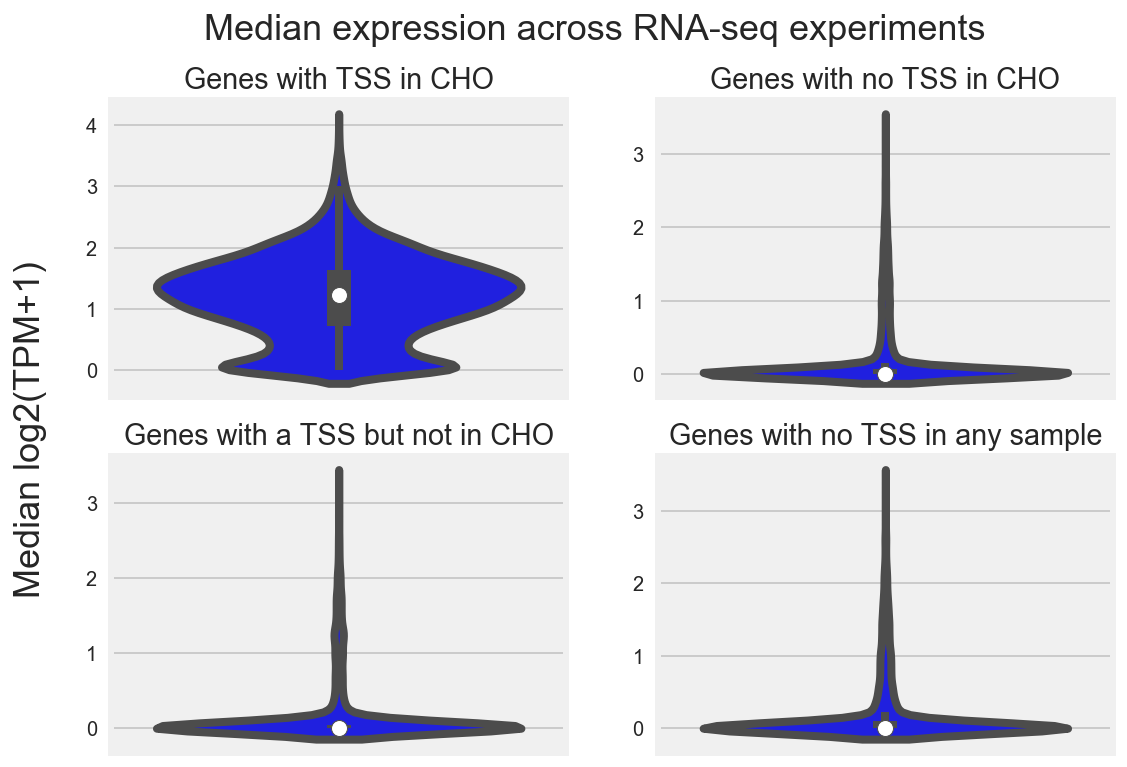

In [111]:
#f,axes = plt.subplots(2,2,sharex=True, sharey=True)
f = plt.figure()
plt.subplot(2,2,1)
sns.violinplot(gene_stats.loc["50%",in_cho],orient='vertical')
plt.title("Genes with TSS in CHO")
#plt.gca().get_yaxis().set_visible(False)
plt.ylabel("")
plt.subplot(2,2,2)
sns.violinplot(gene_stats.loc["50%",not_in_cho],orient='vertical')
plt.title("Genes with no TSS in CHO")
#plt.gca().get_yaxis().set_visible(False)
plt.ylabel("")
plt.subplot(2,2,3)
sns.violinplot(gene_stats.loc["50%",in_any_sample_but_cho],orient='vertical')
plt.title("Genes with a TSS but not in CHO")
#plt.gca().get_yaxis().set_visible(False)
plt.ylabel("")

plt.subplot(2,2,4)
sns.violinplot(gene_stats.loc["50%",in_no_sample],orient='vertical')
plt.title("Genes with no TSS in any sample")
#plt.gca().get_yaxis().set_visible(False)
plt.ylabel("")

suplabel("y","Median log2(TPM+1)",label_prop={"fontsize":18})

plt.suptitle("Median expression across RNA-seq experiments",fontsize=18)
# if not os.path.exists("Results/RNAseq_Compare"):
#     os.mkdir(outdir)
    
plt.savefig(os.path.join(outdir,"RNAseq_CHO_with_TSS.png"))


In [16]:
from plot_tss_results import helper_save

### Make directory

In [17]:
out_dir = "Results/Figures/SuppFigure_RNA"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

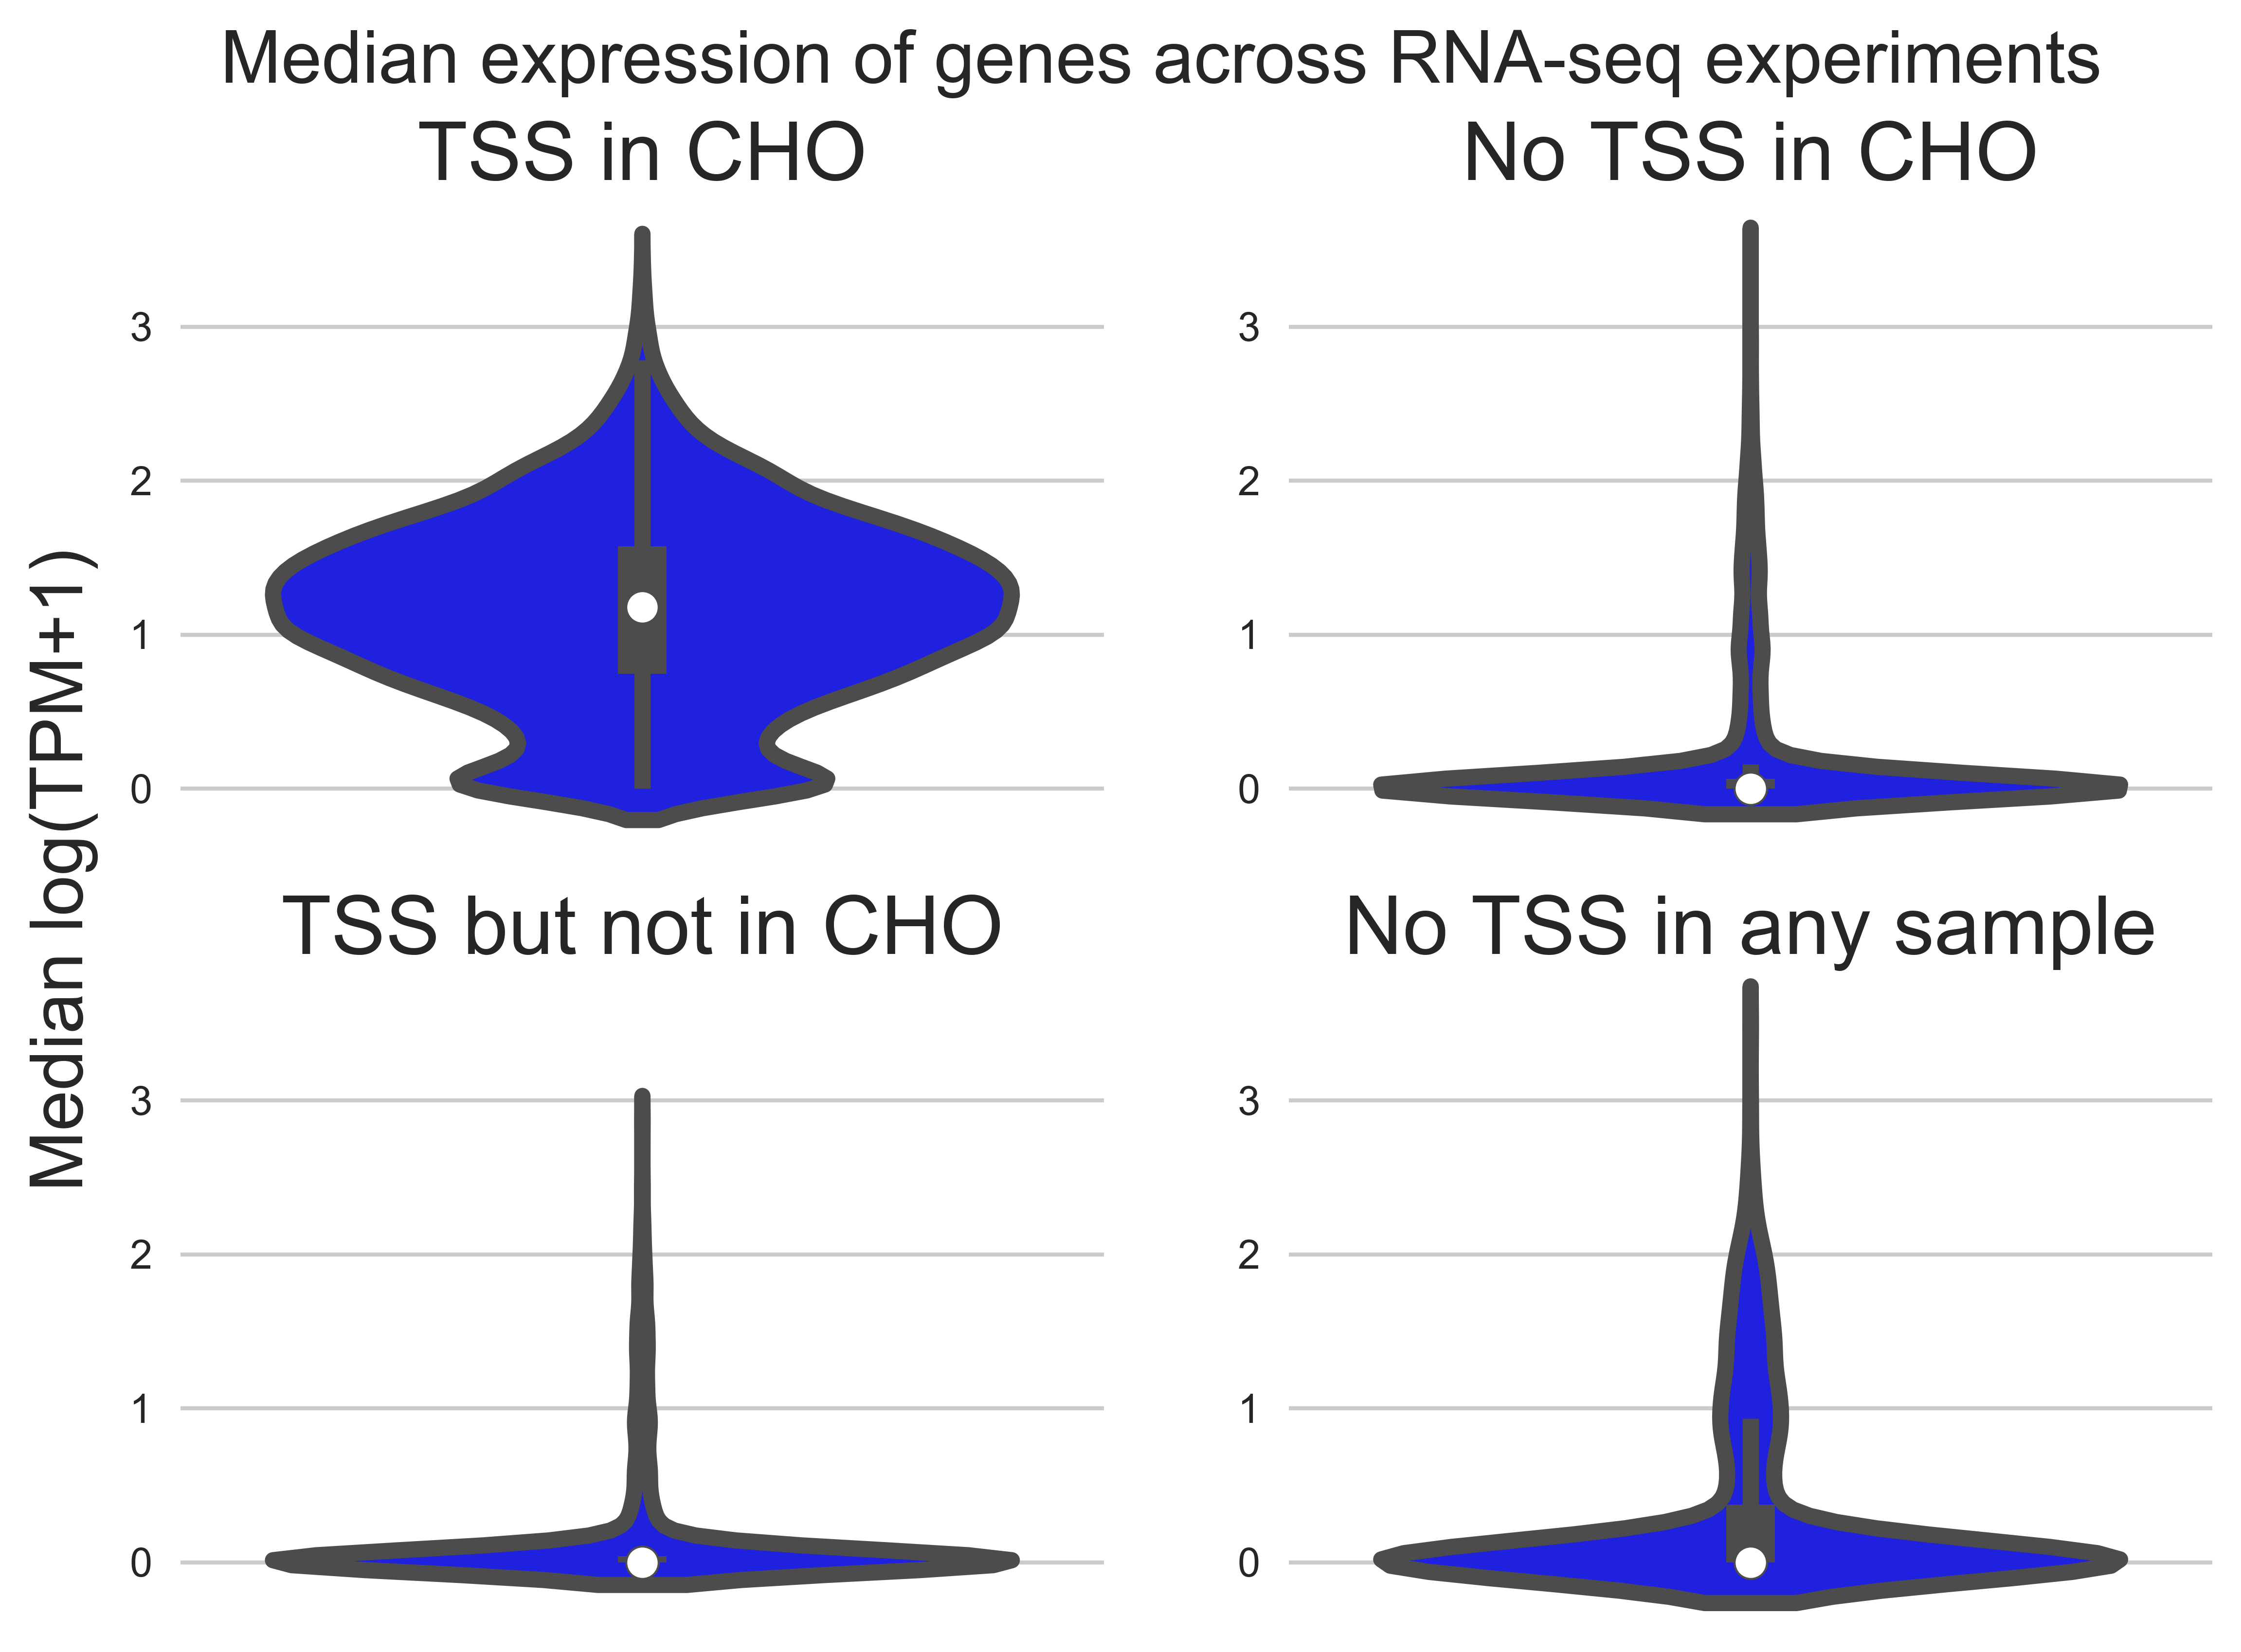

In [48]:
def check_lims(all_ylim,curr_ylim):
    if curr_ylim[0] < all_ylim[0]:
        all_ylim[0] = curr_ylim[0]

    if curr_ylim[1] > all_ylim[1]:
        all_ylim[1] = curr_ylim[1]
    return all_ylim

f,axes = plt.subplots(nrows=2, ncols=2,squeeze=False,dpi=300)
all_ylim = [np.infty,-np.infty]

plt.subplot(2,2,1)
ax = sns.violinplot(gene_stats.loc["50%",in_cho],orient='vertical')
all_ylim = check_lims(all_ylim,plt.ylim())
plt.title("TSS in CHO")
plt.ylabel("")

plt.subplot(2,2,2)
ax = sns.violinplot(gene_stats.loc["50%",not_in_cho],orient='vertical')
all_ylim = check_lims(all_ylim,plt.ylim())
plt.title("No TSS in CHO")
plt.ylabel("")

plt.subplot(2,2,3)
ax = sns.violinplot(gene_stats.loc["50%",in_any_sample_but_cho],orient='vertical')
all_ylim = check_lims(all_ylim,plt.ylim())
plt.title("TSS but not in CHO")
plt.ylabel("")

plt.subplot(2,2,4)
ax = sns.violinplot(gene_stats.loc["50%",in_no_sample],orient='vertical')
all_ylim = check_lims(all_ylim,plt.ylim())
plt.title("No TSS in any sample")
plt.ylabel("")


for ax in f.axes:
    ax.set_ylim(curr_ylim)
    
suplabel("y","Median log(TPM+1)",label_prop={"fontsize":18},labelpad=15)
plt.suptitle("Median expression of genes across RNA-seq experiments",fontsize=18)


helper_save(os.path.join(out_dir,"RNAseq_CHO_with_TSS.png"))



## Load RNA tissue matrix and compare 

In [ ]:
#tissue_f = "/data/isshamie/TSS/Processed/RNA_Total/"